<a href="https://colab.research.google.com/github/peeush-agarwal/week-based-learning/blob/master/Projects/MNIST/MNIST_Predictions_For_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ! unzip train.csv.zip
# ! unzip test.csv.zip

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.style.use('dark_background')

In [6]:
# train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
# test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

print('Raw data:')
print(f'- Train data: {train_df.shape}')
print(f'- Test data: {test_df.shape}')

# Train Data has 
# 1. label <= Column 0
# 2. Pixels <= Column 1 to Column 784

# Test Data has 
# 1. Pixels <= Column 0 to Column 783

train_labels = train_df['label']
train_df.drop('label', axis=1, inplace=True)

print('After fetchin label from train data:')
print(f'- Label data: {train_labels.shape}')
print(f'- Train data: {train_df.shape}')
print(f'- Test data: {test_df.shape}')

Raw data:
- Train data: (42000, 785)
- Test data: (28000, 784)
After fetchin label from train data:
- Label data: (42000,)
- Train data: (42000, 784)
- Test data: (28000, 784)


In [7]:
# Split train into Train and Validation dataset
X_train, X_validation, y_train, y_validation = train_test_split(train_df, train_labels, test_size = 0.2, random_state = 42)

print(f'X_train:{X_train.shape}')
print(f'y_train:{y_train.shape}')
print(f'X_validation:{X_validation.shape}')
print(f'y_validation:{y_validation.shape}')


X_train:(33600, 784)
y_train:(33600,)
X_validation:(8400, 784)
y_validation:(8400,)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision

In [9]:
print(X_train.values[0].shape)
item = torch.tensor(X_train.values[0], dtype=torch.float)
print(item.size())
item_1 = item.view(1, 28, 28)
print(item_1.size())

(784,)
torch.Size([784])
torch.Size([1, 28, 28])


In [0]:
class MNIST_Dataset(Dataset):
    def __init__(self, features, labels):
        self.inputs = torch.tensor(features.values, dtype=torch.float)
        self.labels = torch.tensor(labels.values)
        
    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        input_item = self.inputs[idx]
        return input_item.view(1, 28, 28), self.labels[idx]

In [0]:
batch_size = 256

In [0]:
trainset = MNIST_Dataset(X_train, y_train)
validset = MNIST_Dataset(X_validation, y_validation)

trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size, shuffle=False, num_workers=2)

In [0]:
def imshow(images, labels):
  plt.figure(figsize=(images.size()[0]*4, 4))
  plt.imshow(images.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.title(f'{[label.item() for label in labels]}')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


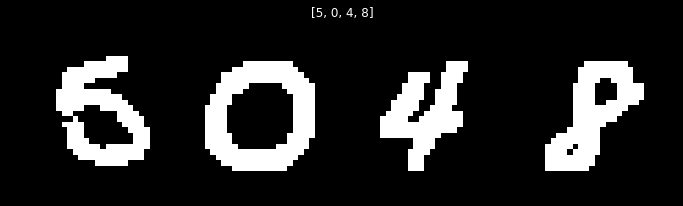

In [14]:
inputs, labels = next(iter(trainloader))

inputs = torchvision.utils.make_grid(inputs[:4])
labels = labels[:4]

imshow(inputs, labels)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
print(device)

cuda:0


In [0]:
class MNIST_CNN(nn.Module):
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1),      # (1, 28, 28) => (32, 28, 28)
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, 3, 1, 1),     # (32, 28, 28) => (32, 28, 28)
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        #nn.MaxPool2d(2, stride=2),      # (32, 28, 28) => (32, 14, 14)
        nn.Conv2d(32, 32, 5, 2, 2),        # (32, 28, 28) => (32, 14, 14)
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 1, 1),     # (32, 14, 14) => (64, 14, 14)
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 1, 1),     # (64, 14, 14) => (64, 14, 14)
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        #nn.MaxPool2d(2, stride=2)      # (64, 14, 14) => (64, 7, 7)
        nn.Conv2d(64, 64, 5, 2, 2),        # (64, 14, 14) => (64, 7, 7)
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(64*7*7, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size()[0], -1)
    out = self.classifier(out)
    return out

In [0]:
model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [19]:
%%time
num_epochs = 80

model.train()

epoch_losses = []
accuracies = []
for epoch in range(num_epochs):
  epoch_loss = 0

  total = 0
  correct = 0

  for batch_id, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    total += len(labels)
    correct += (preds == labels).sum()

    if batch_id != 0 and batch_id % 128 == 0:
      print(f'Epoch:{epoch}, batch:{batch_id}, loss:{loss}, avg_loss:{epoch_loss/batch_id}, accuracy={100.0*correct/total}')
  
  epoch_loss = epoch_loss/len(trainloader)
  accuracy = 100.0*correct/total
  print(f'Epoch loss: {epoch_loss}, accuracy={accuracy}')
  epoch_losses.append(epoch_loss)
  accuracies.append(accuracy)

print('Training completed')

Epoch:0, batch:128, loss:0.14393766224384308, avg_loss:0.4815910166944377, accuracy=87.33345031738281
Epoch loss: 0.4705176960225358, accuracy=87.48511505126953
Epoch:1, batch:128, loss:0.09797843545675278, avg_loss:0.10868430649861693, accuracy=97.2625961303711
Epoch loss: 0.10766019768109827, accuracy=97.27678680419922
Epoch:2, batch:128, loss:0.0840207114815712, avg_loss:0.07350666458660271, accuracy=98.11652374267578
Epoch loss: 0.0729039021993451, accuracy=98.11607360839844
Epoch:3, batch:128, loss:0.06253547966480255, avg_loss:0.056958537839818746, accuracy=98.6373519897461
Epoch loss: 0.056550769191799743, accuracy=98.63095092773438
Epoch:4, batch:128, loss:0.0361558198928833, avg_loss:0.04914502191240899, accuracy=98.7160873413086
Epoch loss: 0.04884257870302959, accuracy=98.7202377319336
Epoch:5, batch:128, loss:0.031632035970687866, avg_loss:0.04141416650963947, accuracy=98.94622039794922
Epoch loss: 0.041082594924691046, accuracy=98.94940185546875
Epoch:6, batch:128, loss:0.

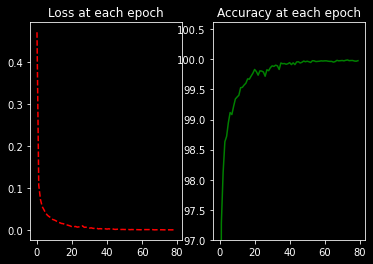

In [20]:
plt.subplot(121)
plt.plot(range(num_epochs), epoch_losses, 'r--')
plt.title('Loss at each epoch')
plt.subplot(122)
plt.plot(range(num_epochs), accuracies, 'g-')
plt.ylim(bottom=97)
plt.title('Accuracy at each epoch')
plt.show()

In [21]:
model.eval()

with torch.no_grad():
  total = 0
  correct = 0
  conf_mat = np.zeros((10, 10))
  for batch_id, data in enumerate(validloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)

    for x, y in zip(preds.cpu().numpy(), labels.cpu().numpy()):
      conf_mat[x][y] += 1

    total += len(labels)
    correct += (preds == labels).sum()
  
  validation_accuracy = 100.0*correct/total

print(f'Validation accuracy: {validation_accuracy}')

Validation accuracy: 99.42857360839844


In [0]:
def plot_conf_matrix(confusion_matrix):
  classes = np.arange(10)
  fig, ax = plt.subplots()
  im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(confusion_matrix.shape[1]),
          yticks=np.arange(confusion_matrix.shape[0]),
          xticklabels=classes, yticklabels=classes,
          ylabel='True label',
          xlabel='Predicted label',
          title='Epoch %d' % epoch)
  thresh = confusion_matrix.max() / 2.
  for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          ax.text(j, i, int(confusion_matrix[i, j]),
                  ha="center", va="center",
                  color="white" if confusion_matrix[i, j] > thresh else "black")
    
  fig.tight_layout()

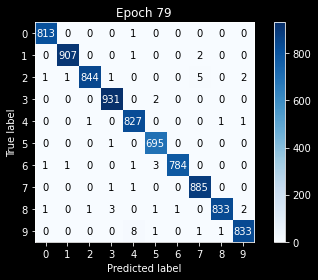

In [23]:
plot_conf_matrix(conf_mat)

In [24]:
test_df.shape

(28000, 784)

In [0]:
class MNIST_Test_Dataset(Dataset):
    def __init__(self, features):
        self.inputs = torch.tensor(features.values, dtype=torch.float)
        
    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return len(self.inputs)

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        input_item = self.inputs[idx]
        return input_item.view(1, 28, 28)

In [0]:
batch_size = 1
testset = MNIST_Test_Dataset(test_df)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False)

In [0]:
def imshow_test(inputs, predictions = None):
  inputs = torchvision.utils.make_grid(inputs[:4])

  plt.figure(figsize=(16, 4))
  plt.imshow(inputs.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  if predictions != None:
    plt.title(predictions)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


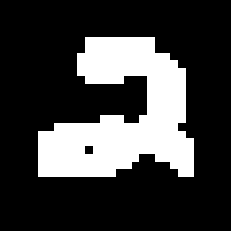

In [49]:
inputs = next(iter(testloader))
imshow_test(inputs)

In [0]:
model.eval()

predictions = {}
with torch.no_grad():
    for batch_id, inputs in enumerate(testloader, 1):
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        predictions[batch_id] = preds.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


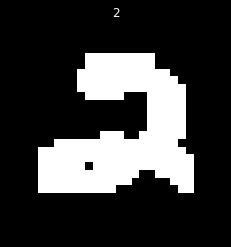

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


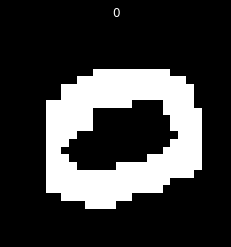

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


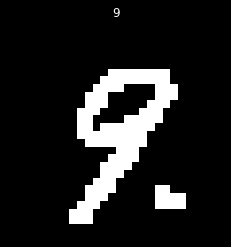

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


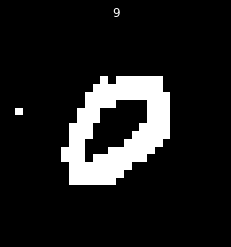

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


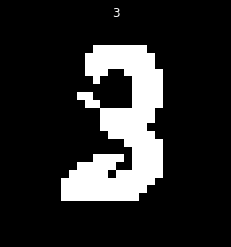

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


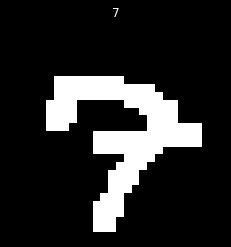

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


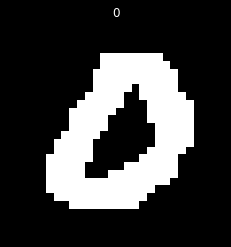

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


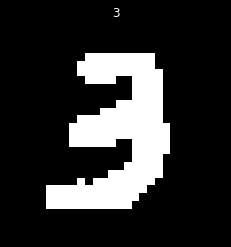

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


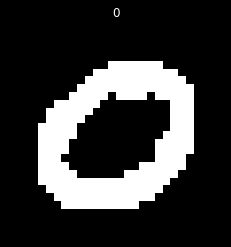

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


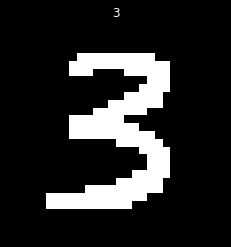

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


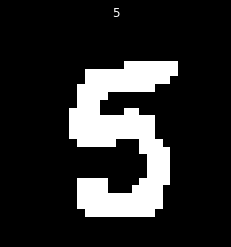

In [50]:
n_predictions = 10
for idx, inputs in enumerate(testloader, 1):
  imshow_test(inputs, predictions[idx])
  if idx > n_predictions:
    break

In [0]:
import csv

with open('predictions_4.csv', mode='w') as csv_file:
    fieldnames = ['ImageId', 'Label']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for k,v in predictions.items():
        writer.writerow({'ImageId': k, 'Label': v})